In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

## 5.4.1 곱셈 계층

In [5]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = self.x * self.y

        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy

In [7]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [9]:
dprice = 1

dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple_price, dtax)
print(dapple, dapple_num)

1.1 200
2.2 110.00000000000001


## 5.4.2 덧셈 계층

In [48]:
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        return x + y
    
    def backward(self, dout):
        return dout, dout

In [50]:
#그림 5-17 forward
apple = 100
orange = 150
apple_num = 2
orange_num = 3
tax = 1.1

mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_price_layer = AddLayer()
mul_tax_layer = MulLayer()

apple_all_price = mul_apple_layer.forward(apple, apple_num)
orange_all_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_price_layer.forward(apple_all_price, orange_all_price)
price_with_tax = mul_tax_layer.forward(all_price, tax)

print(apple_all_price, orange_all_price, all_price, price_with_tax)

200 450 650 715.0000000000001


In [12]:
#그림 5-17 backward

dprice = 1
dall_price, dtax = mul_tax_layer.backward(1)
dapple_all_price, dorange_all_price = add_price_layer.backward(dall_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_all_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_all_price)

print(dprice, dall_price, dapple_all_price, dorange_all_price, dapple_num, dapple, dorange, dorange_num, dtax)

1 1.1 1.1 1.1 110.00000000000001 2.2 3.3000000000000003 165.0 650


## 5.5 활성화 함수 계층 구현하기
### 5.5.1 ReLU 계층

In [13]:
class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [42]:
relu_layer = ReLU

print(relu_layer.forward(relu_layer, np.array([5])))
print(relu_layer.backward(relu_layer, np.array([13])))

[5]
[13]


### 5.5.2 Sigmoid 계층

In [37]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out
    
    def backward(self, dout):
        return dout * self.out * (1 - self.out)

In [46]:
sigmoid_layer = Sigmoid

print(sigmoid_layer.forward(sigmoid_layer, 5))
print(sigmoid_layer.backward(sigmoid_layer, 1))

0.9933071490757153
0.006648056670790033


## 5.6 Affine/Softmax 계층 구현하기
### 5.6.1 Affine 계층

In [51]:
X = np.random.rand(2) # (1, 2)
W = np.random.rand(2, 3) # (2, 3)
b = np.random.rand(3) # (1, 3)

print(X.shape, W.shape, b.shape)

y = np.dot(X, W) + b

print(y.shape) # (1, 3)

(2,) (2, 3) (3,)
(3,)


In [52]:
X_dot_W = np.array([[0, 0, 0], [10, 10, 10]])
B = np.array([1, 2, 3])

print(X_dot_W)
print(X_dot_W + B)

[[ 0  0  0]
 [10 10 10]]
[[ 1  2  3]
 [11 12 13]]


In [53]:
dY = np.array([[1, 2, 3], [4, 5, 6]])
print(dY)
dB = np.sum(dY, axis=0)
print(dB)

[[1 2 3]
 [4 5 6]]
[5 7 9]


### 2차원용 Affine

In [ ]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.b = np.sum(dout, axis=0)

        return dx

### 5.6.3 Softmax-with-Loss 계층

In [3]:
import sys, os
sys.path.append(os.pardir)
from common.functions import softmax, cross_entropy_error

In [4]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(y, t)

        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

### 5.7.1 신경망 학습의 전체 그림

In [6]:
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std):
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params["b1"] = np.zeros(hidden_size)
        self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["b2"] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers["Affine1"] = Affine(self.params["W1"], self.params["b1"])
        self.layers["Relu1"] = Relu()
        self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])

        return accuracy
    
    def numerical_gradient(self, x, t):
        grads = {}
        grads["W1"] = numerical_gradient(self.loss, self.params["W1"])
        grads["b1"] = numerical_gradient(self.loss, self.params["b1"])
        grads["W2"] = numerical_gradient(self.loss, self.params["W2"])
        grads["b2"] = numerical_gradient(self.loss, self.params["b2"])

        return grads
    
    def gradient(self, x, t):
        #순전파
        self.loss(x, t)
        
        #역전파
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 이해 안되면 common/layers/의 Affine 클래스 참조하세요.
        grads = {}
        grads["W1"] = self.layers["Affine1"].dW 
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW
        grads["b2"] = self.layers["Affine2"].db

        return grads

### 5.7.3 오차역전파법으로 구한 기울기 검증하기

In [7]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(f"key: {diff}")

key: 9.821061997929637e-07
key: 1.0904181849873482e-05
key: 7.288939145928493e-09
key: 1.4082794891900896e-07


### 5.7.4 오차역전파법을 사용한 학습 구현하기

In [11]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(784, 50, 10)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch) # loss(predict -> softmax with loss) ->  backprop(반대로 gradient 구하기)

    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key] # network.gradient에서 구한 grad를 적용하여 파라미터 갱신하기

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(train_acc, test_acc)

0.08951666666666666 0.0898
0.1162 0.1203
0.1031 0.1019
0.12931666666666666 0.134
0.10838333333333333 0.1103
0.11718333333333333 0.1179
0.124 0.1229
0.15613333333333335 0.1568
0.16523333333333334 0.1703
0.16351666666666667 0.1683
0.17545 0.1787
0.2049 0.2041
0.18431666666666666 0.1844
0.1814 0.1801
0.17586666666666667 0.1744
0.18021666666666666 0.1828
0.20301666666666668 0.2028
0.21466666666666667 0.2135
0.19306666666666666 0.1936
0.2586833333333333 0.2594
0.138 0.1373
0.17915 0.1765
0.19825 0.1957
0.28981666666666667 0.2938
0.2547 0.2566
0.25046666666666667 0.2514
0.30846666666666667 0.3112
0.34625 0.3504
0.33575 0.3404
0.3616666666666667 0.3652
0.37783333333333335 0.3832
0.4044833333333333 0.4134
0.43366666666666664 0.446
0.4129333333333333 0.42
0.3571166666666667 0.3618
0.3430666666666667 0.3467
0.3494 0.3534
0.3687 0.376
0.34021666666666667 0.3481
0.34355 0.3486
0.3683166666666667 0.3729
0.3260166666666667 0.3327
0.34518333333333334 0.3517
0.40348333333333336 0.4111
0.41695 0.4279
0

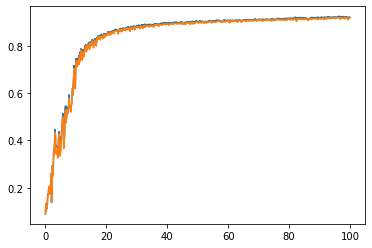

In [19]:
import matplotlib.pyplot as plt

x = np.arange(0, 100, 0.1)
y = test_acc_list
y2 = train_acc_list
y3 = train_loss_list

plt.plot(x, y)
plt.plot(x, y2)
plt.show()